In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])
model = st.multivariate_normal(mean=mu,cov=covar)

In [3]:
N = [50,100,200]
gamma = [0.1,1.0,5.0]


In [4]:
def fix_string(x):
    return np.array([float(z) for z in x[1:-1].split(' ') if z is not ""])

In [5]:
df = pd.read_csv("portfolio_results.csv",index_col=0)

In [6]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else:
        return var-mean

def sum_weights(weights):
    return np.sum(weights)-1

def mle_mv_gaussian(mean_est,cov_est,gamma,average=False):
    init_weights = np.ones((5))/5
    constraints = [{'type':'eq','fun':sum_weights}]
    res = minimize(mean_variance,init_weights,args=(mean_est,cov_est,gamma,
                                                    average),
                  constraints=constraints,
                  bounds=[(0,None)]*5)
    return res.x

In [7]:
N_TRIALS = 1000

In [35]:
for l in range(N_TRIALS):
    for j in range(len(gamma)):
        for i in range(len(N)):
            n = N[i]
            samples = model.rvs(n)
            sample_mean = np.mean(samples,axis=0)
            sample_cov = np.cov(samples.T)

            # perform mle
            weights = mle_mv_gaussian(sample_mean,
                                    sample_cov,
                                    gamma[j])
            results = {'w_star': weights,'method':'SAA','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)

In [30]:
for j in range(len(gamma)):
    weights = mle_mv_gaussian(mu,
                                covar,
                                gamma[j])
    results = {'w_star': weights,'method':'True','gamma':gamma[j],'N':200}
    df = df.append(results,ignore_index=True)

In [12]:
#df['w_star'] = df['w_star'].apply(lambda x:fix_string(x))
df['mean_variance'] = df.apply(lambda x:mean_variance(x['w_star'],
                                                      mu,
                                                      covar,
                                                      x['gamma']),
                                axis=1)
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))

Text(0.5, 1.0, 'Gamma = 1.0')

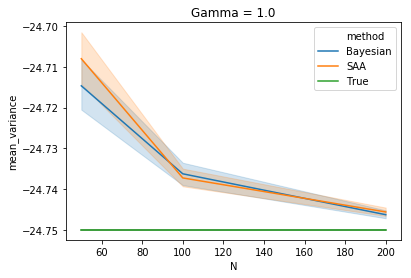

In [13]:
gamma_df = df[df['gamma']==1.0]
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,color='g')
plt.title('Gamma = 1.0')

Text(0.5, 1.0, 'Gamma = 0.1')

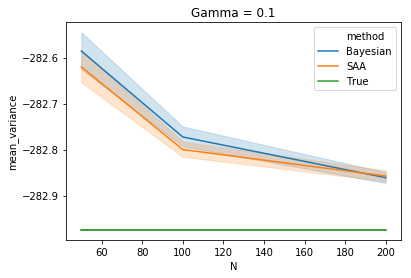

In [14]:
gamma_df = df[df['gamma']==0.1]
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,color='g')
plt.title('Gamma = 0.1')

Text(0.5, 1.0, 'Gamma = 5.0')

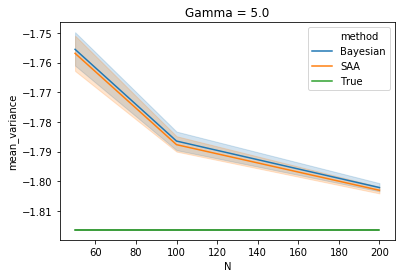

In [15]:
gamma_df = df[df['gamma']==5.0]
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*3,color='g')
plt.title('Gamma = 5.0')

## compute divergence of weights

In [154]:
def compute_wasserstein(x,true_weights_dict):
    result = st.wasserstein_distance(true_weights_dict[x['gamma']],x['w_star'])
    return result

In [159]:
true_weights_dict = {}
for j in range(len(gamma)): 
    true_weights = df[(df.gamma==gamma[j]) &(df.method=='True')]['w_star'].iloc[0]
    true_weights_dict[gamma[j]] = true_weights
df['wasserstein_distance'] = df.apply(
        lambda x:compute_wasserstein(x,true_weights_dict),axis=1)

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


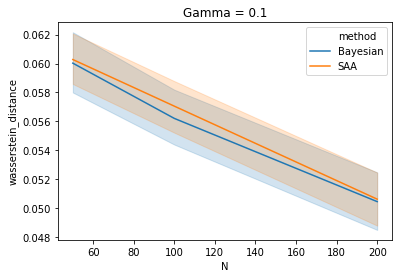

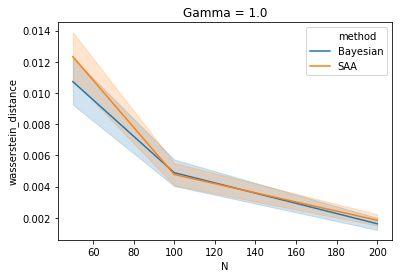

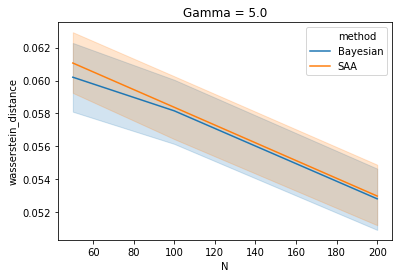

In [160]:
for j in range(len(gamma)): 
    gamma_df = df[(df.gamma==gamma[j]) & (df.method != 'True')]
    ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['wasserstein_distance'], 
                      hue=gamma_df['method'])
    #plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3,color='g')
    plt.title('Gamma = {0}'.format(gamma[j]))
    plt.show()

In [165]:
df = df.drop(['kl_div'],axis=1)

In [166]:
df.to_csv('portfolio_results.csv')